# Homework Description
- English to Chinese (Traditional) Translation
  - Input: an English sentence         (e.g.		tom is a student .)
  - Output: the Chinese translation  (e.g. 		湯姆 是 個 學生 。)

- TODO
    - Train a simple RNN seq2seq to acheive translation
    - Switch to transformer model to boost performance
    - Apply Back-translation to furthur boost performance

In [1]:
!nvidia-smi

Tue Apr  5 05:31:47 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
|  0%   45C    P8    11W / 275W |    202MiB / 11175MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Download and import required packages

In [2]:
# !pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
# !pip install --upgrade jupyter ipywidgets

In [3]:
# !git clone https://github.com/pytorch/fairseq.git
# !cd fairseq && git checkout 9a1c497
# !pip install --upgrade ./fairseq/

In [4]:
import sys
import pdb
import pprint
import logging
import os
import random
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# Fix random seed

In [5]:
seed = 10942178
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Dataset

## En-Zh Bilingual Parallel Corpus
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - Raw: 398,066 (sentences)   
    - Processed: 393,980 (sentences)
    

## Testdata
- Size: 4,000 (sentences)
- **Chinese translation is undisclosed. The provided (.zh) file is psuedo translation, each line is a '。'**

## Dataset Download

In [6]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted2020.tgz",
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/test.tgz",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test/test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test/test.zh'} {prefix/'test.raw.zh'}
!rm -rf {prefix/'test'}

raw.en
raw.zh
test/
test/test.zh
test/test.en


## Language

In [7]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [8]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## Preprocess files

In [9]:
import re

def strQ2B(ustring):
    """Full width -> half width"""
    # reference:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # Full width space: direct conversion
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # Full width chars (except space) conversion
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [10]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/train_dev.raw.clean.en & zh exists. skipping clean.
/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/test.raw.clean.en & zh exists. skipping clean.


In [11]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## Split into train/valid

In [12]:
valid_ratio = 0.01 # 3000~4000 would suffice
train_ratio = 1 - valid_ratio

In [13]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
Out of vocabulary (OOV) has been a major problem in machine translation. This can be alleviated by using subword units.
- We will use the [sentencepiece](#kudo-richardson-2018-sentencepiece) package
- select 'unigram' or 'byte-pair encoding (BPE)' algorithm

In [14]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' works as well
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [15]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/test.en exists. skipping spm_encode.
/home/weiweichi/weichi/HW5/DATA/rawdata/ted2020/test.zh exists. skipping spm_encode.


In [16]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## Binarize the data with fairseq

In [17]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# Configuration for experiments

In [18]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "./checkpoints/transformer-bt",
    source_lang = "zh",
    target_lang = "en",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging package logs ordinary messages
- wandb logs the loss, bleu, etc. in the training process

In [19]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA Environments

In [20]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2022-04-05 05:31:57 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-04-05 05:31:57 | INFO | fairseq.utils | rank   0: capabilities =  6.1  ; total memory = 10.913 GB ; name = NVIDIA GeForce GTX 1080 Ti              
2022-04-05 05:31:57 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# Dataloading

## We borrow the TranslationTask from fairseq
* used to load the binarized data created above
* well-implemented data iterator (dataloader)
* built-in task.source_dictionary and task.target_dictionary are also handy
* well-implemented beach search decoder

In [21]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-04-05 05:31:57 | INFO | fairseq.tasks.translation | [zh] dictionary: 7992 types
2022-04-05 05:31:57 | INFO | fairseq.tasks.translation | [en] dictionary: 7992 types


In [22]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-04-05 05:31:57 | INFO | hw5.seq2seq | loading data for epoch 1
2022-04-05 05:31:57 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2022-04-05 05:31:57 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2022-04-05 05:31:57 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390041 examples
2022-04-05 05:31:57 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2022-04-05 05:31:57 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2022-04-05 05:31:57 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3939 examples


In [23]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  53, 3134, 3107,   34,  408, 1223, 3895,  670,    9, 1038,  498,  148,
        1689,  364,  129, 1050, 1103,   34,  408,  158,  607, 3268,  306,    9,
        1105,    2]),
 'target': tensor([  35,   22,  440,   27,    5,  850,  261,  172,    6,   29,  800,    6,
         184,  164,   99, 1178,  374,  804,  257,   41,    5,  313,  868,   42,
          27,   61, 1836,   18,  184, 1147, 1404,   21,    6,    6,  320,    7,
           2])}
'Source: 我們培植了一些果蠅它們的腦部被隨機地安置了一些可以光驅動的細胞'
('Target: so we bred flies whose brains were more or less randomly peppered '
 'with cells that were light addressable .')


# Dataset iterator

* Controls every batch to contain no more than N tokens, which optimizes GPU memory efficiency
* Shuffles the training set for every epoch
* Ignore sentences exceeding maximum length
* Pad all sentences in a batch to the same length, which enables parallel computing by GPU
* Add eos and shift one token
    - teacher forcing: to train the model to predict the next token based on prefix, we feed the right shifted target sequence as the decoder input.
    - generally, prepending bos to the target would do the job (as shown below)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - in fairseq however, this is done by moving the eos token to the begining. Empirically, this has the same effect. For instance:
    ```
    # output target (target) and Decoder input (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```



In [24]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-04-05 05:31:57 | WARNING | fairseq.tasks.fairseq_task | 2,565 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[1811, 3245, 3729, 1898, 732, 226, 3630, 2905, 2594, 196]


{'id': tensor([2001, 3666]),
 'nsentences': 2,
 'ntokens': 15,
 'net_input': {'src_tokens': tensor([[   1,    5,  299, 1257,  843,  611,  413,    2],
          [   1,   53,  968,  407,  177,  362,   33,    2]]),
  'src_lengths': tensor([7, 7]),
  'prev_output_tokens': tensor([[   2, 1166,  812,  542,  519,  538,    7,    1],
          [   2,  151,  741,   22,  657,  718,   18,   33]])},
 'target': tensor([[1166,  812,  542,  519,  538,    7,    2,    1],
         [ 151,  741,   22,  657,  718,   18,   33,    2]])}

* each batch is a python dict, with string key and Tensor value. Contents are described below:
```python
batch = {
    "id": id, # id for each example 
    "nsentences": len(samples), # batch size (sentences)
    "ntokens": ntokens, # batch size (tokens)
    "net_input": {
        "src_tokens": src_tokens, # sequence in source language
        "src_lengths": src_lengths, # sequence length of each example before padding
        "prev_output_tokens": prev_output_tokens, # right shifted target, as mentioned above.
    },
    "target": target, # target sequence
}
```

# Model Architecture
* We again inherit fairseq's encoder, decoder and model, so that in the testing phase we can directly leverage fairseq's beam search decoder.

In [25]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Seq2Seq
- Composed of **Encoder** and **Decoder**
- Recieves inputs and pass to **Encoder** 
- Pass the outputs from **Encoder** to **Decoder**
- **Decoder** will decode according to outputs of previous timesteps as well as **Encoder** outputs  
- Once done decoding, return the **Decoder** outputs

In [26]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# Model Initialization

In [27]:
# # HINT: transformer architecture
from fairseq.models.transformer import (
    TransformerEncoder, 
    TransformerDecoder,
)

def build_model(args, task):
    """ build a model instance based on hyperparameters """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # token embeddings
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # encoder decoder
    # HINT: TODO: switch to TransformerEncoder & TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)

    # sequence to sequence model
    model = Seq2Seq(args, encoder, decoder)
    
    # initialization for seq2seq model is important, requires extra handling
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # weight initialization
    model.apply(init_params)
    return model

## Architecture Related Configuration

For strong baseline, please refer to the hyperparameters for *transformer-base* in Table 3 in [Attention is all you need](#vaswani2017)

In [28]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=6,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# HINT: these patches on parameters for Transformer
def add_transformer_args(args):
    args.encoder_attention_heads=8
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=8
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [29]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [30]:
model = build_model(arch_args, task)
logger.info(model)

2022-04-05 05:31:59 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(7992, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bia

# Optimization

## Loss: Label Smoothing Regularization
* let the model learn to generate less concentrated distribution, and prevent over-confidence
* sometimes the ground truth may not be the only answer. thus, when calculating loss, we reserve some probability for incorrect labels
* avoids overfitting

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [31]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，the cross-entropy when target is one-hot. following line is same as F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        #  reserve some probability for other labels. thus when calculating cross-entropy, 
        # equivalent to summing the log probs of all labels
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # when calculating cross-entropy, add the loss of other labels
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# generally, 0.1 is good enough
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root scheduling is important to the stability when training Transformer. It's later used on RNN as well.
Update the learning rate according to the following equation. Linearly increase the first stage, then decay proportionally to the inverse square root of timestep.
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$

In [32]:
def get_rate(d_model, step_num, warmup_step):
    # TODO: Change lr from constant to the equation shown above
    return d_model**(-0.5) * min(step_num ** (-0.5), step_num * warmup_step ** (-1.5))

In [33]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * get_rate(self.model_size, step, self.warmup)

## Scheduling Visualized

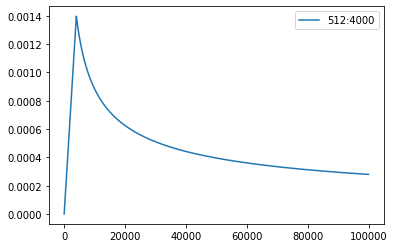

In [34]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# Training Procedure

## Training

In [35]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # gradient accumulation: update every accum_steps samples
    
    stats = {"loss": []}
    scaler = GradScaler() # automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # gradient accumulation: update every accum_steps samples
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # mixed precision training
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # grad norm clipping prevents gradient exploding
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference
To prevent overfitting, validation is required every epoch to validate the performance on unseen data.
- the procedure is essensially same as training, with the addition of inference step
- after validation we can save the model weights

Validation loss alone cannot describe the actual performance of the model
- Directly produce translation hypotheses based on current model, then calculate BLEU with the reference translation
- We can also manually examine the hypotheses' quality
- We use fairseq's sequence generator for beam search to generate translation hypotheses

In [36]:
# fairseq's beam search generator
# given model and input seqeunce, produce translation hypotheses by beam search
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # convert from Tensor to human readable sentence
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # for each sample, collect the input, hypothesis and reference, later be used to calculate BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 indicates using the top hypothesis in beam
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [37]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # do inference
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# Save and Load Model Weights


In [38]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# Main
## Training loop

In [39]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [40]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-04-05 05:32:02 | INFO | hw5.seq2seq | task: TranslationTask
2022-04-05 05:32:02 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-04-05 05:32:02 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-04-05 05:32:02 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-04-05 05:32:02 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-04-05 05:32:02 | INFO | hw5.seq2seq | num. model params: 52,324,352 (num. trained: 52,324,352)
2022-04-05 05:32:02 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [41]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-04-05 05:32:02 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326738]
2022-04-05 05:32:02 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/transformer-bt/checkpoint_last.pt!


train epoch 1:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 05:44:19 | INFO | hw5.seq2seq | training loss: 5.6079
2022-04-05 05:44:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

/home/weiweichi/.local/lib/python3.8/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/weiweichi/.local/lib/python3.8/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  unfin_idx = idx // beam_size


2022-04-05 05:44:58 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 05:44:58 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 05:44:58 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 05:44:58 | INFO | hw5.seq2seq | example source: 艾曼達 , 能否請您分享您如何失去手臂的 ?
2022-04-05 05:44:58 | INFO | hw5.seq2seq | example hypothesis: johnia , can you can tell you how do you get your hands ?
2022-04-05 05:44:58 | INFO | hw5.seq2seq | example reference: so amanda , would you please tell us how you lost your arm ?
2022-04-05 05:44:58 | INFO | hw5.seq2seq | validation loss:	4.2844
2022-04-05 05:44:58 | INFO | hw5.seq2seq | BLEU = 3.37 29.9/6.3/1.8/0.5 (BP = 0.910 ratio = 0.914 hyp_len = 69583 ref_len = 76142)
2022-04-05 05:44:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/c

train epoch 2:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 05:57:15 | INFO | hw5.seq2seq | training loss: 3.8616
2022-04-05 05:57:15 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 05:57:50 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 05:57:50 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 05:57:50 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 05:57:50 | INFO | hw5.seq2seq | example source: 在未來兩年 , 我的工作是設計一個總體計畫並於十年內執行本計劃-當然 , 這需要眾人攜手合作 。
2022-04-05 05:57:50 | INFO | hw5.seq2seq | example hypothesis: in the next two years , my job is to design a sumarian project , and that's a project that's going to work in a decade , of course , that's going to work together .
2022-04-05 05:57:50 | INFO | hw5.seq2seq | example reference: that is my job for the next two years , to design an entire master plan , and then for the next 10 years to implement it of course , with so many other people .
2022-04-05 05:57:50 | INFO | hw5.seq2seq | validation loss:	

train epoch 3:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 06:10:08 | INFO | hw5.seq2seq | training loss: 3.2907
2022-04-05 06:10:08 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 06:10:38 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 06:10:38 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 06:10:38 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 06:10:38 | INFO | hw5.seq2seq | example source: 如果我們能夠改變這個動力 , 首先 , 創造人口密度更高更適合居住的城市...
2022-04-05 06:10:38 | INFO | hw5.seq2seq | example hypothesis: if we can change this movement , the first density of creating density is better for the city .
2022-04-05 06:10:38 | INFO | hw5.seq2seq | example reference: if we can change the dynamic , by first of all creating cities that are denser and more livable . . .
2022-04-05 06:10:38 | INFO | hw5.seq2seq | validation loss:	3.1152
2022-04-05 06:10:38 | INFO | hw5.seq2seq | BLEU = 11.67 52.8/21.8/10.6/5.3 (BP = 0.734 ratio = 0.764 hyp_len = 58167 ref_len = 761

train epoch 4:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 06:22:59 | INFO | hw5.seq2seq | training loss: 3.0452
2022-04-05 06:22:59 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 06:23:31 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 06:23:31 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 06:23:31 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 06:23:31 | INFO | hw5.seq2seq | example source: 他將與我同行 ,
2022-04-05 06:23:31 | INFO | hw5.seq2seq | example hypothesis: he's going to work with me .
2022-04-05 06:23:31 | INFO | hw5.seq2seq | example reference: he is coming with me .
2022-04-05 06:23:31 | INFO | hw5.seq2seq | validation loss:	2.9893
2022-04-05 06:23:31 | INFO | hw5.seq2seq | BLEU = 14.10 50.6/21.6/10.7/5.5 (BP = 0.885 ratio = 0.891 hyp_len = 67837 ref_len = 76142)
2022-04-05 06:23:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-bt/checkpoint4.pt
2022-04-05 06:23:35 | INFO | hw5.seq2

train epoch 5:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 06:35:53 | INFO | hw5.seq2seq | training loss: 2.9167
2022-04-05 06:35:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 06:36:27 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 06:36:27 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 06:36:27 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 06:36:27 | INFO | hw5.seq2seq | example source: 這叫快速通關走道或vip票
2022-04-05 06:36:27 | INFO | hw5.seq2seq | example hypothesis: it's called a rapid reference or vip .
2022-04-05 06:36:27 | INFO | hw5.seq2seq | example reference: they call them fast track or vip tickets .
2022-04-05 06:36:27 | INFO | hw5.seq2seq | validation loss:	2.9207
2022-04-05 06:36:27 | INFO | hw5.seq2seq | BLEU = 15.33 49.4/21.5/10.8/5.6 (BP = 0.962 ratio = 0.963 hyp_len = 73317 ref_len = 76142)
2022-04-05 06:36:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-bt/checkpoint5.pt
20

train epoch 6:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 06:48:48 | INFO | hw5.seq2seq | training loss: 2.8097
2022-04-05 06:48:48 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 06:49:20 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 06:49:20 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 06:49:20 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 06:49:20 | INFO | hw5.seq2seq | example source: 可能我們會想要把它用在某些結構上之類的 。
2022-04-05 06:49:20 | INFO | hw5.seq2seq | example hypothesis: maybe we would like to use it for some structures .
2022-04-05 06:49:20 | INFO | hw5.seq2seq | example reference: probably we're going to want it for some structures , and so on .
2022-04-05 06:49:20 | INFO | hw5.seq2seq | validation loss:	2.7867
2022-04-05 06:49:20 | INFO | hw5.seq2seq | BLEU = 16.51 52.7/24.0/12.6/6.9 (BP = 0.907 ratio = 0.911 hyp_len = 69386 ref_len = 76142)
2022-04-05 06:49:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/

train epoch 7:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 07:01:40 | INFO | hw5.seq2seq | training loss: 2.6867
2022-04-05 07:01:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 07:02:15 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 07:02:15 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 07:02:15 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 07:02:15 | INFO | hw5.seq2seq | example source: 最後還有支付能力的問題
2022-04-05 07:02:15 | INFO | hw5.seq2seq | example hypothesis: and then finally , there's a problem of payment .
2022-04-05 07:02:15 | INFO | hw5.seq2seq | example reference: and then there's finally there's the affordability question .
2022-04-05 07:02:15 | INFO | hw5.seq2seq | validation loss:	2.7277
2022-04-05 07:02:15 | INFO | hw5.seq2seq | BLEU = 17.33 49.9/22.9/12.0/6.7 (BP = 0.996 ratio = 0.996 hyp_len = 75829 ref_len = 76142)
2022-04-05 07:02:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/tran

train epoch 8:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 07:14:34 | INFO | hw5.seq2seq | training loss: 2.5979
2022-04-05 07:14:34 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 07:15:06 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 07:15:06 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 07:15:06 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 07:15:06 | INFO | hw5.seq2seq | example source: 這相當於每年從海裡撈出全體中國人的重量 。
2022-04-05 07:15:06 | INFO | hw5.seq2seq | example hypothesis: that's the equivalent of the weight of the chinese every year .
2022-04-05 07:15:06 | INFO | hw5.seq2seq | example reference: that's the equivalent of the human weight of china taken out of the sea every year .
2022-04-05 07:15:06 | INFO | hw5.seq2seq | validation loss:	2.6677
2022-04-05 07:15:06 | INFO | hw5.seq2seq | BLEU = 18.86 54.3/26.1/14.2/8.1 (BP = 0.939 ratio = 0.940 hyp_len = 71606 ref_len = 76142)
2022-04-05 07:15:08 | INFO | hw5.seq2seq | saved epoch checkpoi

train epoch 9:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 07:27:27 | INFO | hw5.seq2seq | training loss: 2.5251
2022-04-05 07:27:27 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 07:27:57 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 07:27:57 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 07:27:57 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 07:27:57 | INFO | hw5.seq2seq | example source: 謝謝 。
2022-04-05 07:27:57 | INFO | hw5.seq2seq | example hypothesis: thank you .
2022-04-05 07:27:57 | INFO | hw5.seq2seq | example reference: thank you .
2022-04-05 07:27:57 | INFO | hw5.seq2seq | validation loss:	2.6663
2022-04-05 07:27:57 | INFO | hw5.seq2seq | BLEU = 17.96 57.8/28.1/15.6/9.0 (BP = 0.823 ratio = 0.837 hyp_len = 63699 ref_len = 76142)
2022-04-05 07:27:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-bt/checkpoint9.pt
2022-04-05 07:27:59 | INFO | hw5.seq2seq | end of epoch 9


train epoch 10:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 07:40:14 | INFO | hw5.seq2seq | training loss: 2.4649
2022-04-05 07:40:14 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 07:40:46 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 07:40:46 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 07:40:46 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 07:40:46 | INFO | hw5.seq2seq | example source: 合作社的成員是自我選拔 。
2022-04-05 07:40:46 | INFO | hw5.seq2seq | example hypothesis: cooperational community members are selfconsulation .
2022-04-05 07:40:46 | INFO | hw5.seq2seq | example reference: the slime mould collective membership is selfselecting .
2022-04-05 07:40:46 | INFO | hw5.seq2seq | validation loss:	2.6272
2022-04-05 07:40:46 | INFO | hw5.seq2seq | BLEU = 19.61 56.3/27.6/15.5/9.1 (BP = 0.907 ratio = 0.911 hyp_len = 69388 ref_len = 76142)
2022-04-05 07:40:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/tra

train epoch 11:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 07:53:03 | INFO | hw5.seq2seq | training loss: 2.4138
2022-04-05 07:53:03 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 07:53:36 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 07:53:36 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 07:53:36 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 07:53:36 | INFO | hw5.seq2seq | example source: 我製作了實體版的 「 笨鳥先飛 」 , 而它不會從應用程式商店下架 。
2022-04-05 07:53:36 | INFO | hw5.seq2seq | example hypothesis: i made physical versions of stupid birds , and it didn't get off the app store .
2022-04-05 07:53:36 | INFO | hw5.seq2seq | example reference: i made a physical version of flappy bird that could never be taken off the app store .
2022-04-05 07:53:36 | INFO | hw5.seq2seq | validation loss:	2.6107
2022-04-05 07:53:36 | INFO | hw5.seq2seq | BLEU = 19.79 55.1/26.8/14.9/8.6 (BP = 0.949 ratio = 0.950 hyp_len = 72354 ref_len = 76142)
2022-04-05 07:53:38 | INFO | h

train epoch 12:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 08:05:54 | INFO | hw5.seq2seq | training loss: 2.3691
2022-04-05 08:05:54 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 08:06:26 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 08:06:26 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 08:06:26 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 08:06:26 | INFO | hw5.seq2seq | example source: 那樣的特質導致一種網路架構 , 這種架構前所未有 , 其後的其它數位網路也無法比擬 。
2022-04-05 08:06:26 | INFO | hw5.seq2seq | example hypothesis: that trait leads to a framework that has never been possible before , and the rest of the digital networks aren't even more likely to compare .
2022-04-05 08:06:26 | INFO | hw5.seq2seq | example reference: that ethos led to a network architecture , a structure that was unlike other digital networks then or since .
2022-04-05 08:06:26 | INFO | hw5.seq2seq | validation loss:	2.6080
2022-04-05 08:06:26 | INFO | hw5.seq2seq | BLEU = 20.10 55.9/27.6/15.5

train epoch 13:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 08:18:45 | INFO | hw5.seq2seq | training loss: 2.3292
2022-04-05 08:18:45 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 08:19:18 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 08:19:18 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 08:19:18 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 08:19:18 | INFO | hw5.seq2seq | example source: 我是個運動員 。 那是我唯一懂得的事 , 也是唯一做過的事 。
2022-04-05 08:19:18 | INFO | hw5.seq2seq | example hypothesis: i'm an athlete . that's the only thing i knew , and that's the only thing i ever did .
2022-04-05 08:19:18 | INFO | hw5.seq2seq | example reference: i was an athlete . that's all i knew . that's all i'd done .
2022-04-05 08:19:18 | INFO | hw5.seq2seq | validation loss:	2.5987
2022-04-05 08:19:18 | INFO | hw5.seq2seq | BLEU = 20.21 56.2/27.8/15.6/9.2 (BP = 0.930 ratio = 0.932 hyp_len = 70986 ref_len = 76142)
2022-04-05 08:19:20 | INFO | hw5.seq2seq | saved epoch

train epoch 14:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 08:31:39 | INFO | hw5.seq2seq | training loss: 2.2930
2022-04-05 08:31:39 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 08:32:11 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 08:32:11 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 08:32:11 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 08:32:11 | INFO | hw5.seq2seq | example source: 我可以想像一個未來 , 在這個未來中 , 我們會很高興看到學齡前兒童與螢幕互動 。
2022-04-05 08:32:11 | INFO | hw5.seq2seq | example hypothesis: i could imagine a future where we would be happy to see preschoolers interacting with screens in the future .
2022-04-05 08:32:11 | INFO | hw5.seq2seq | example reference: i can envision a future where we would be excited to see a preschooler interacting with a screen .
2022-04-05 08:32:11 | INFO | hw5.seq2seq | validation loss:	2.6085
2022-04-05 08:32:11 | INFO | hw5.seq2seq | BLEU = 20.19 56.4/27.9/15.7/9.2 (BP = 0.925 ratio = 0.927 hyp_len = 70613 

train epoch 15:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 08:44:31 | INFO | hw5.seq2seq | training loss: 2.2615
2022-04-05 08:44:31 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 08:45:03 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 08:45:03 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 08:45:03 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 08:45:03 | INFO | hw5.seq2seq | example source: 裡面沒有鋪設好的道路 , 也沒有水泥的停車位地基 。 在拖車停車位之間也沒有圍籬 。
2022-04-05 08:45:03 | INFO | hw5.seq2seq | example hypothesis: there are no roads in there , no cement status , no fence between the trailer parking spaces .
2022-04-05 08:45:03 | INFO | hw5.seq2seq | example reference: it didn't have any paved roads in it , it didn't have the concrete slabs , it didn't have fencing to portion off your trailer slot from other trailer slots .
2022-04-05 08:45:03 | INFO | hw5.seq2seq | validation loss:	2.6016
2022-04-05 08:45:03 | INFO | hw5.seq2seq | BLEU = 20.18 56.1/27.8/15.7/9

train epoch 16:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 08:57:21 | INFO | hw5.seq2seq | training loss: 2.2308
2022-04-05 08:57:21 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 08:57:54 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 08:57:54 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 08:57:54 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 08:57:54 | INFO | hw5.seq2seq | example source: 嬰兒不會説話 , 對吧 ? 」
2022-04-05 08:57:54 | INFO | hw5.seq2seq | example hypothesis: babies don't talk , right ? "
2022-04-05 08:57:54 | INFO | hw5.seq2seq | example reference: infants can't talk , right ? "
2022-04-05 08:57:54 | INFO | hw5.seq2seq | validation loss:	2.6035
2022-04-05 08:57:54 | INFO | hw5.seq2seq | BLEU = 20.14 56.2/27.8/15.6/9.1 (BP = 0.928 ratio = 0.930 hyp_len = 70818 ref_len = 76142)
2022-04-05 08:57:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-bt/checkpoint16.pt
2022-04-05 08:57:56 

train epoch 17:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 09:10:12 | INFO | hw5.seq2seq | training loss: 2.2027
2022-04-05 09:10:12 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 09:10:46 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 09:10:46 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 09:10:46 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 09:10:46 | INFO | hw5.seq2seq | example source: 而身為老師、妻子這自然也是我每天都面對的問題
2022-04-05 09:10:46 | INFO | hw5.seq2seq | example hypothesis: and as a teacher , as a wife , it's a natural problem for me every day .
2022-04-05 09:10:46 | INFO | hw5.seq2seq | example reference: so as a teacher and as a spouse , this is , of course , a problem i confront every day .
2022-04-05 09:10:46 | INFO | hw5.seq2seq | validation loss:	2.6128
2022-04-05 09:10:46 | INFO | hw5.seq2seq | BLEU = 20.42 55.0/27.2/15.4/9.0 (BP = 0.957 ratio = 0.957 hyp_len = 72902 ref_len = 76142)
2022-04-05 09:10:48 | INFO | hw5.seq2seq | saved 

train epoch 18:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 09:23:04 | INFO | hw5.seq2seq | training loss: 2.1784
2022-04-05 09:23:04 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 09:23:36 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 09:23:36 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 09:23:36 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 09:23:36 | INFO | hw5.seq2seq | example source: 後來我們真的這樣做了 , 那是好事 。
2022-04-05 09:23:36 | INFO | hw5.seq2seq | example hypothesis: and we actually did that , and that's a good thing .
2022-04-05 09:23:36 | INFO | hw5.seq2seq | example reference: so we did that . it was a good thing .
2022-04-05 09:23:36 | INFO | hw5.seq2seq | validation loss:	2.6152
2022-04-05 09:23:36 | INFO | hw5.seq2seq | BLEU = 20.08 55.9/27.5/15.6/9.2 (BP = 0.929 ratio = 0.931 hyp_len = 70892 ref_len = 76142)
2022-04-05 09:23:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-bt/c

train epoch 19:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 09:35:56 | INFO | hw5.seq2seq | training loss: 2.1555
2022-04-05 09:35:56 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 09:36:28 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 09:36:28 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 09:36:28 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 09:36:28 | INFO | hw5.seq2seq | example source: 他們選擇昂貴的檢測他們選擇為體弱的老人動手術
2022-04-05 09:36:28 | INFO | hw5.seq2seq | example hypothesis: they chose expensive tests , and they chose surgery for the weak elderly .
2022-04-05 09:36:28 | INFO | hw5.seq2seq | example reference: you choose an expensive lab test , you choose to operate on an old and frail patient .
2022-04-05 09:36:28 | INFO | hw5.seq2seq | validation loss:	2.6194
2022-04-05 09:36:28 | INFO | hw5.seq2seq | BLEU = 20.60 55.5/27.6/15.6/9.2 (BP = 0.952 ratio = 0.953 hyp_len = 72573 ref_len = 76142)
2022-04-05 09:36:30 | INFO | hw5.seq2seq | saved 

train epoch 20:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 09:48:48 | INFO | hw5.seq2seq | training loss: 2.1331
2022-04-05 09:48:48 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 09:49:21 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 09:49:21 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 09:49:21 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 09:49:21 | INFO | hw5.seq2seq | example source: 我是說 , 這些事都在他眼下發生
2022-04-05 09:49:21 | INFO | hw5.seq2seq | example hypothesis: i mean , it's all happening under his eyes .
2022-04-05 09:49:21 | INFO | hw5.seq2seq | example reference: i mean after all , this whole business happened on his watch .
2022-04-05 09:49:21 | INFO | hw5.seq2seq | validation loss:	2.6316
2022-04-05 09:49:21 | INFO | hw5.seq2seq | BLEU = 19.87 55.9/27.4/15.3/9.0 (BP = 0.927 ratio = 0.929 hyp_len = 70761 ref_len = 76142)
2022-04-05 09:49:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/tra

train epoch 21:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 10:01:40 | INFO | hw5.seq2seq | training loss: 2.1126
2022-04-05 10:01:40 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 10:02:12 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 10:02:12 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 10:02:12 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 10:02:12 | INFO | hw5.seq2seq | example source: 有50%的車禍發生在十字路口
2022-04-05 10:02:12 | INFO | hw5.seq2seq | example hypothesis: fifty percent of crashes happened at crossroads .
2022-04-05 10:02:12 | INFO | hw5.seq2seq | example reference: fifty percent of crashes happen at intersections .
2022-04-05 10:02:12 | INFO | hw5.seq2seq | validation loss:	2.6387
2022-04-05 10:02:12 | INFO | hw5.seq2seq | BLEU = 20.13 55.9/27.6/15.6/9.1 (BP = 0.930 ratio = 0.932 hyp_len = 70984 ref_len = 76142)
2022-04-05 10:02:14 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-

train epoch 22:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 10:14:29 | INFO | hw5.seq2seq | training loss: 2.0929
2022-04-05 10:14:29 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 10:15:00 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 10:15:00 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 10:15:00 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 10:15:00 | INFO | hw5.seq2seq | example source: 我們要問自己這些問題 , 不論這是多麼的令人不快 。
2022-04-05 10:15:00 | INFO | hw5.seq2seq | example hypothesis: we need to ask ourselves these questions , no matter how uncomfortable they are .
2022-04-05 10:15:00 | INFO | hw5.seq2seq | example reference: we have to ask ourselves these questions , however unpalatable .
2022-04-05 10:15:00 | INFO | hw5.seq2seq | validation loss:	2.6468
2022-04-05 10:15:00 | INFO | hw5.seq2seq | BLEU = 19.82 56.3/27.8/15.6/9.1 (BP = 0.913 ratio = 0.916 hyp_len = 69777 ref_len = 76142)
2022-04-05 10:15:03 | INFO | hw5.seq2seq | saved epoch check

train epoch 23:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 10:27:19 | INFO | hw5.seq2seq | training loss: 2.0746
2022-04-05 10:27:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 10:27:51 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 10:27:51 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 10:27:51 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 10:27:51 | INFO | hw5.seq2seq | example source: 有些會太靠近恆星 , 會被烤熟 , 有些則太遙遠 , 會被冰凍 。
2022-04-05 10:27:51 | INFO | hw5.seq2seq | example hypothesis: some get too close to a star , they get ripped , others get so far away , they get frozen .
2022-04-05 10:27:51 | INFO | hw5.seq2seq | example reference: some will be too close to a star and they'll fry , some will be too far away and they'll freeze .
2022-04-05 10:27:51 | INFO | hw5.seq2seq | validation loss:	2.6610
2022-04-05 10:27:51 | INFO | hw5.seq2seq | BLEU = 20.28 56.0/27.7/15.7/9.2 (BP = 0.933 ratio = 0.935 hyp_len = 71172 ref_len = 76142)
2022-04-05

train epoch 24:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 10:40:09 | INFO | hw5.seq2seq | training loss: 2.0584
2022-04-05 10:40:09 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 10:40:42 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 10:40:42 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 10:40:42 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 10:40:42 | INFO | hw5.seq2seq | example source: 我認為大多數的人都不想死但我認為大多數的人都想要控制自己的死亡過程
2022-04-05 10:40:42 | INFO | hw5.seq2seq | example hypothesis: i think most people don't want to die , but i think most people want to control their own mortality .
2022-04-05 10:40:42 | INFO | hw5.seq2seq | example reference: i think most people don't want to be dead , but i do think most people want to have some control over how their dying process proceeds .
2022-04-05 10:40:42 | INFO | hw5.seq2seq | validation loss:	2.6650
2022-04-05 10:40:42 | INFO | hw5.seq2seq | BLEU = 19.95 56.1/27.7/15.5/9.0 (BP = 0.926 ratio = 

train epoch 25:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 10:53:00 | INFO | hw5.seq2seq | training loss: 2.0421
2022-04-05 10:53:00 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 10:53:32 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 10:53:32 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 10:53:32 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 10:53:32 | INFO | hw5.seq2seq | example source: 目前我們正在土耳其建造一座更長一點的橋 , 我們也設計了義大利的墨西拿海峽大橋 , 正在等待開始動工的日子 , 天知道是何時 。
2022-04-05 10:53:32 | INFO | hw5.seq2seq | example hypothesis: right now , we're building a much longer bridge in turkey , and we're also designing mexican navy bridges that are waiting for the day to start work , and god knows when .
2022-04-05 10:53:32 | INFO | hw5.seq2seq | example reference: we're currently working on one in turkey which is a bit longer , and we've designed the messina bridge in italy , which is just waiting to get started with construction one day , who knows when .
20

train epoch 26:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 11:05:52 | INFO | hw5.seq2seq | training loss: 2.0269
2022-04-05 11:05:52 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 11:06:25 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 11:06:25 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 11:06:25 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 11:06:25 | INFO | hw5.seq2seq | example source: 國王在如雷掌聲中接過皇冠、權仗亨利·克里斯托夫登上離地20米的寶座
2022-04-05 11:06:25 | INFO | hw5.seq2seq | example hypothesis: the king had received crowns and authorities in thunder's applause , henry christopher had climbed up 20 meters away from the ground .
2022-04-05 11:06:25 | INFO | hw5.seq2seq | example reference: after receiving his ornate crown and scepter , henry christophe ascended his throne , towering 20 meters in the air .
2022-04-05 11:06:25 | INFO | hw5.seq2seq | validation loss:	2.6820
2022-04-05 11:06:25 | INFO | hw5.seq2seq | BLEU = 19.76 56.0/27.4/15.2/8.9 (BP = 

train epoch 27:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 11:18:43 | INFO | hw5.seq2seq | training loss: 2.0111
2022-04-05 11:18:43 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 11:19:15 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 11:19:15 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 11:19:15 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 11:19:15 | INFO | hw5.seq2seq | example source: 他們不知道那有多荒謬 , 而我知道 。
2022-04-05 11:19:15 | INFO | hw5.seq2seq | example hypothesis: they didn't know how ridiculous that was , and i knew .
2022-04-05 11:19:15 | INFO | hw5.seq2seq | example reference: now , they don't know how ridiculous that is , but i do .
2022-04-05 11:19:15 | INFO | hw5.seq2seq | validation loss:	2.6998
2022-04-05 11:19:15 | INFO | hw5.seq2seq | BLEU = 20.01 56.2/27.7/15.6/9.1 (BP = 0.924 ratio = 0.926 hyp_len = 70544 ref_len = 76142)
2022-04-05 11:19:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkp

train epoch 28:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 11:31:33 | INFO | hw5.seq2seq | training loss: 1.9982
2022-04-05 11:31:33 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 11:32:06 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 11:32:06 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 11:32:06 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 11:32:06 | INFO | hw5.seq2seq | example source: 這概念就是大家所知的 「 熱輻射 」 。
2022-04-05 11:32:06 | INFO | hw5.seq2seq | example hypothesis: this is the idea that we know about thermal radiation .
2022-04-05 11:32:06 | INFO | hw5.seq2seq | example reference: this is a concept known as thermal radiation .
2022-04-05 11:32:06 | INFO | hw5.seq2seq | validation loss:	2.6944
2022-04-05 11:32:06 | INFO | hw5.seq2seq | BLEU = 19.94 55.4/27.1/15.2/8.9 (BP = 0.939 ratio = 0.940 hyp_len = 71598 ref_len = 76142)
2022-04-05 11:32:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/tran

train epoch 29:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 11:44:24 | INFO | hw5.seq2seq | training loss: 1.9845
2022-04-05 11:44:24 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 11:44:56 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 11:44:56 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 11:44:56 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 11:44:56 | INFO | hw5.seq2seq | example source: 老實說 , 我們其實可以提前完成這個企畫 , 但我想我們因為這些喝茶休憩時間多做了三周 。
2022-04-05 11:44:56 | INFO | hw5.seq2seq | example hypothesis: and honestly , we can actually finish this project ahead of time , but i think we've done more than three weeks for tea .
2022-04-05 11:44:56 | INFO | hw5.seq2seq | example reference: and to be honest with you , we could have finished earlier , but i think it took us three weeks because of all those tea breaks .
2022-04-05 11:44:56 | INFO | hw5.seq2seq | validation loss:	2.7088
2022-04-05 11:44:56 | INFO | hw5.seq2seq | BLEU = 19.71 55.9/27.3/15.3

train epoch 30:   0%|          | 0/800 [00:00<?, ?it/s]

2022-04-05 11:57:16 | INFO | hw5.seq2seq | training loss: 1.9727
2022-04-05 11:57:16 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 11:57:48 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 11:57:48 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 11:57:48 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 11:57:48 | INFO | hw5.seq2seq | example source: 所以這是個好消息
2022-04-05 11:57:48 | INFO | hw5.seq2seq | example hypothesis: so that's the good news .
2022-04-05 11:57:48 | INFO | hw5.seq2seq | example reference: so that was good news .
2022-04-05 11:57:48 | INFO | hw5.seq2seq | validation loss:	2.7192
2022-04-05 11:57:48 | INFO | hw5.seq2seq | BLEU = 19.79 55.7/27.1/15.2/8.9 (BP = 0.931 ratio = 0.933 hyp_len = 71074 ref_len = 76142)
2022-04-05 11:57:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer-bt/checkpoint30.pt
2022-04-05 11:57:50 | INFO | hw5.seq2s

# Submission

In [42]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python3 ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/transformer-bt'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/transformer-bt/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['./checkpoints/transformer-bt/checkpoint30.pt', './checkpoints/transformer-bt/checkpoint29.pt', './checkpoints/transformer-bt/checkpoint28.pt', './checkpoints/transformer-bt/checkpoint27.pt', './checkpoints/transformer-bt/checkpoint26.pt']
Finished writing averaged checkpoint to ./checkpoints/transformer-bt/avg_last_5_checkpoint.pt


## Confirm model weights used to generate submission

In [43]:
# checkpoint_last.pt : latest epoch
# checkpoint_best.pt : highest validation bleu
# avg_last_5_checkpoint.pt:　the average of last 5 epochs
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-04-05 11:57:53 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer-bt/avg_last_5_checkpoint.pt: step=unknown loss=2.719242811203003 bleu=19.786939734245298
2022-04-05 11:57:53 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/27 [00:00<?, ?it/s]

2022-04-05 11:58:25 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2022-04-05 11:58:25 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2022-04-05 11:58:25 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with the `force` parameter.
2022-04-05 11:58:25 | INFO | hw5.seq2seq | example source: 飛蚊可能不太明顯通常是如此
2022-04-05 11:58:25 | INFO | hw5.seq2seq | example hypothesis: now , floaters may not be obvious , usually .
2022-04-05 11:58:25 | INFO | hw5.seq2seq | example reference: floaters may be only barely distinguishable most of the time .
2022-04-05 11:58:25 | INFO | hw5.seq2seq | validation loss:	2.6695
2022-04-05 11:58:25 | INFO | hw5.seq2seq | BLEU = 20.47 56.6/28.1/15.9/9.4 (BP = 0.927 ratio = 0.929 hyp_len = 70750 ref_len = 76142)


## Generate Prediction

In [44]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # do inference
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # sort based on the order before preprocess
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

# Back-translation

## Train a backward translation model

1. Switch the source_lang and target_lang in **config** 
2. Change the savedir in **config** (eg. "./checkpoints/transformer-back")
3. Train model

## Generate synthetic data with backward model 

### Download monolingual data

In [45]:
mono_dataset_name = 'mono'

In [46]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    "https://github.com/yuhsinchan/ML2022-HW5Dataset/releases/download/v1.0.2/ted_zh_corpus.deduped.gz",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

ted_zh_corpus.deduped.gz is exist, skip downloading


### TODO: clean corpus

1. remove sentences that are too long or too short
2. unify punctuation

hint: you can use clean_s() defined above to do this

In [47]:
def clean_mono_corpus(mono_prefix, l1, l2, max_len=1000, min_len=1):
    if Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1}').exists() and Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l2}').exists():
        print(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{mono_prefix}/ted_zh_corpus.deduped', 'r') as l1_in_f:
        with open(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1}', 'w') as l1_out_f:
            with open(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l2}', 'w') as l2_out_f:
                for s1 in l1_in_f:
                    s1 = s1.strip()
                    s1 = clean_s(s1, l1)
                    s1_len = len_s(s1, l1)
                    if min_len > 0: # remove short sentence
                        if s1_len < min_len:
                            continue
                    if max_len > 0: # remove long sentence
                        if s1_len > max_len:
                            continue
                    print(s1, file=l1_out_f)
                    print('.', file=l2_out_f)

In [48]:
print(mono_prefix)
clean_mono_corpus(mono_prefix, 'zh','en')

/home/weiweichi/weichi/HW5/DATA/rawdata/mono
/home/weiweichi/weichi/HW5/DATA/rawdata/mono/ted_zh_corpus.deduped.clean.zh & en exists. skipping clean.


In [49]:
!head {data_prefix+'.clean.'+'zh'} -n 5
!head {data_prefix+'.clean.'+'en'} -n 5

非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !
Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .


### TODO: Subword Units

Use the spm model of the backward model to tokenize the data into subword units

hint: spm model is located at DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [50]:
for lang in ['zh', 'en']:
    out_path = mono_prefix/f'mono.tok.{lang}'
    if out_path.exists():
        print(f"{out_path} exists. skipping spm_encode.")
    else:
        with open(mono_prefix/f'mono.tok.{lang}', 'w') as out_f:
            with open(mono_prefix/f'ted_zh_corpus.deduped.clean.{lang}', 'r') as in_f:
                for line in in_f:
                    line = line.strip()
                    tok = spm_model.encode(line, out_type=str)
                    print(' '.join(tok), file=out_f)

/home/weiweichi/weichi/HW5/DATA/rawdata/mono/mono.tok.zh exists. skipping spm_encode.
/home/weiweichi/weichi/HW5/DATA/rawdata/mono/mono.tok.en exists. skipping spm_encode.


### Binarize

use fairseq to binarize data

In [51]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

DATA/data-bin/mono exists, will not overwrite!


### TODO: Generate synthetic data with backward model

Add binarized monolingual data to the original data directory, and name it with "split_name"

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

then you can use 'generate_prediction(model, task, split="split_name")' to generate translation prediction

In [52]:
# Add binarized monolingual data to the original data directory, and name it with "split_name"
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [53]:
# hint: do prediction on split='mono' to create prediction_file
generate_prediction(model, task, split="mono", outfile="./DATA/rawdata/mono/mono_prediction.txt")

2022-04-05 11:58:30 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2022-04-05 11:58:30 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2022-04-05 11:58:30 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono zh-en 781713 examples


prediction:   0%|          | 0/1715 [00:00<?, ?it/s]

In [54]:
!head {'./DATA/rawdata/mono/mono_prediction.txt'} -n 5

in the mid16th century , italians were captivated by a kind of male singer whose incredible range contained notes previously thought impossible for adult men .
but this gift came at a very high price .
to prevent them from turning their voices , these singers were castrated before puberty , and they stopped hormonal changes so that their voices would sink beneath their voices .
known as castrati , their light , angelic voices were renowned throughout europe , until this brutal process was banned in the 19th century .
although the growth of the vocal folds can produce an extraordinary range , naturally developing voices have tremendous possibilities .


### TODO: Create new dataset

1. Combine the prediction data with monolingual data
2. Use the original spm model to tokenize data into Subword Units
3. Binarize data with fairseq

In [55]:
# Combine prediction_file (.en) and mono.zh (.zh) into a new dataset.
# 
# hint: tokenize prediction_file with the spm model
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
# hint: use fairseq to binarize these two files again
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = './DATA/rawdata/mono/mono.tok' # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python3 -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

DATA/data-bin/synthetic exists, will not overwrite!


In [56]:
# create a new dataset from all the files prepared above
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

Created new dataset "ted2020_with_mono"

1. Change the datadir in **config** ("./DATA/data-bin/ted2020_with_mono")
2. Switch back the source_lang and target_lang in **config** ("en", "zh")
2. Change the savedir in **config** (eg. "./checkpoints/transformer-bt")
3. Train model

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html
11. https://colab.research.google.com/github/ga642381/ML2021-Spring/blob/main/HW05/HW05.ipynb

In [57]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono",
    savedir = "./checkpoints/transformer",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=35,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10, 
    # when decoding, post process sentence by removing sentencepiece symbols and jieba tokenization.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=True,
)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

2022-04-05 13:03:45 | ERROR | wandb.jupyter | Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: weiweichi (use `wandb login --relogin` to force relogin)


In [58]:
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-04-05 13:03:47 | INFO | fairseq.tasks.translation | [en] dictionary: 7992 types
2022-04-05 13:03:47 | INFO | fairseq.tasks.translation | [zh] dictionary: 7992 types


In [59]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-04-05 13:03:47 | INFO | hw5.seq2seq | loading data for epoch 1
2022-04-05 13:03:47 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.en
2022-04-05 13:03:47 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.zh
2022-04-05 13:03:47 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2022-04-05 13:03:47 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2022-04-05 13:03:47 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2022-04-05 13:03:47 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 781713 examples
2022-04-05 13:03:47 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020_with_mono/valid.en-zh.en
2022-04-05 13:03:47 | I

In [60]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  35,   22,  440,   27,    5,  850,  261,  172,    6,   29,  800,    6,
         184,  164,   99, 1178,  374,  804,  257,   41,    5,  313,  868,   42,
          27,   61, 1836,   18,  184, 1147, 1404,   21,    6,    6,  320,    7,
           2]),
 'target': tensor([  53, 3134, 3107,   34,  408, 1223, 3895,  670,    9, 1038,  498,  148,
        1689,  364,  129, 1050, 1103,   34,  408,  158,  607, 3268,  306,    9,
        1105,    2])}
('Source: so we bred flies whose brains were more or less randomly peppered '
 'with cells that were light addressable .')
'Target: 我們培植了一些果蠅它們的腦部被隨機地安置了一些可以光驅動的細胞'


In [61]:
demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2022-04-05 13:03:47 | WARNING | fairseq.tasks.fairseq_task | 2,565 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[1643, 1630, 3670, 1642, 413, 2460, 3921, 681, 2996, 302]


{'id': tensor([2710, 1186]),
 'nsentences': 2,
 'ntokens': 18,
 'net_input': {'src_tokens': tensor([[  19,  269,   80,   31,   88,  617,    7,    2],
          [  19,  185,   56,   18, 1119, 2760,    7,    2]]),
  'src_lengths': tensor([8, 8]),
  'prev_output_tokens': tensor([[   2,   40,  158, 1028,  336,  125,  444,  162,   10,    1,    1,    1,
              1,    1,    1,    1],
          [   2, 2375, 1979,  309, 2515,    9,  120,  782,   10,    1,    1,    1,
              1,    1,    1,    1]])},
 'target': tensor([[  40,  158, 1028,  336,  125,  444,  162,   10,    2,    1,    1,    1,
             1,    1,    1,    1],
         [2375, 1979,  309, 2515,    9,  120,  782,   10,    2,    1,    1,    1,
             1,    1,    1,    1]])}

In [62]:
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=6,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

def add_transformer_args(args):
    args.encoder_attention_heads=8
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=8
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # patches on default parameters for Transformer (those not set above)
    from fairseq.models.transformer import base_architecture
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [63]:
model = build_model(arch_args, task)
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001)
)
sequence_generator = task.build_generator([model], config)

In [64]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [65]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-04-05 13:03:49 | INFO | hw5.seq2seq | task: TranslationTask
2022-04-05 13:03:49 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-04-05 13:03:49 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-04-05 13:03:49 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-04-05 13:03:49 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-04-05 13:03:49 | INFO | hw5.seq2seq | num. model params: 52,324,352 (num. trained: 52,324,352)
2022-04-05 13:03:49 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [66]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-04-05 22:15:33 | INFO | hw5.seq2seq | training loss: 3.8386
2022-04-05 22:15:33 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-05 22:16:02 | INFO | hw5.seq2seq | example source: and in that sense of trying to get you out of your normal orbit , and to try to get you to pay attention to a story about someone who's given up smoking for the month of ramadan , she has to know something about a global audience .
2022-04-05 22:16:02 | INFO | hw5.seq2seq | example hypothesis: 在那種情況下 , 試圖讓你脫離正常的軌道 , 試圖讓你關注一個故事 , 關於一個被放棄的拉瑪丹月份 , 她必須知道一個關於全球觀眾的故事 。
2022-04-05 22:16:02 | INFO | hw5.seq2seq | example reference: 才能將身為聽眾的你拉出你的群落並試著讓你關注一個在回教齋月期間一個回民戒煙的故事她必須了解全球的聽眾
2022-04-05 22:16:02 | INFO | hw5.seq2seq | validation loss:	3.1111
2022-04-05 22:16:02 | INFO | hw5.seq2seq | BLEU = 25.44 58.5/33.5/20.2/12.8 (BP = 0.954 ratio = 0.955 hyp_len = 106579 ref_len = 111605)
2022-04-05 22:16:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint23.pt
2022-04-05 22:16:06 | INFO | hw5.seq2seq | end of epoch 23


train epoch 24:   0%|          | 0/1647 [00:00<?, ?it/s]

2022-04-05 22:39:33 | INFO | hw5.seq2seq | training loss: 3.8339
2022-04-05 22:39:33 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-05 22:40:03 | INFO | hw5.seq2seq | example source: but we know that the proper study of mankind is man , to borrow from alexander pope .
2022-04-05 22:40:03 | INFO | hw5.seq2seq | example hypothesis: 但我們知道人類正確的研究是人類 , 借用亞歷山大教授的話 。
2022-04-05 22:40:03 | INFO | hw5.seq2seq | example reference: 不過我們知道正確的研究人類要用真人 , 我借用亞歷山大.波普的話 。
2022-04-05 22:40:03 | INFO | hw5.seq2seq | validation loss:	3.0989
2022-04-05 22:40:03 | INFO | hw5.seq2seq | BLEU = 25.17 57.7/33.0/19.9/12.6 (BP = 0.959 ratio = 0.959 hyp_len = 107072 ref_len = 111605)
2022-04-05 22:40:05 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint24.pt
2022-04-05 22:40:05 | INFO | hw5.seq2seq | end of epoch 24


train epoch 25:   0%|          | 0/1647 [00:00<?, ?it/s]

2022-04-05 23:03:35 | INFO | hw5.seq2seq | training loss: 3.8236
2022-04-05 23:03:35 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-05 23:04:04 | INFO | hw5.seq2seq | example source: thank you .
2022-04-05 23:04:04 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2022-04-05 23:04:04 | INFO | hw5.seq2seq | example reference: 謝謝 。
2022-04-05 23:04:04 | INFO | hw5.seq2seq | validation loss:	3.0971
2022-04-05 23:04:04 | INFO | hw5.seq2seq | BLEU = 25.37 58.6/33.6/20.4/12.9 (BP = 0.945 ratio = 0.947 hyp_len = 105640 ref_len = 111605)
2022-04-05 23:04:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/weiweichi/weichi/HW5/checkpoints/transformer/checkpoint25.pt
2022-04-05 23:04:06 | INFO | hw5.seq2seq | end of epoch 25


train epoch 26:   0%|          | 0/1647 [00:00<?, ?it/s]

In [ ]:
# averaging a few checkpoints can have a similar effect to ensemble
checkdir=config.savedir
!python3 ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['./checkpoints/transformer'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='./checkpoints/transformer/avg_last_5_checkpoint.pt')
Traceback (most recent call last):
  File "./fairseq/scripts/average_checkpoints.py", line 158, in <module>
    main()
  File "./fairseq/scripts/average_checkpoints.py", line 143, in main
    args.inputs = last_n_checkpoints(
  File "./fairseq/scripts/average_checkpoints.py", line 93, in last_n_checkpoints
    raise Exception(
Exception: ('Found {} checkpoint files but need at least {}', 1, 5)


In [ ]:
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2022-04-05 04:55:19 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/transformer/avg_last_5_checkpoint.pt!
2022-04-05 04:55:19 | INFO | hw5.seq2seq | begin validation


validation:   0%|          | 0/22 [00:00<?, ?it/s]

2022-04-05 04:55:54 | INFO | hw5.seq2seq | example source: i loved every minute of it .
2022-04-05 04:55:54 | INFO | hw5.seq2seq | example hypothesis: 我聽過很多人 。
2022-04-05 04:55:54 | INFO | hw5.seq2seq | example reference: 我愛那次演出的每一分鐘 。
2022-04-05 04:55:54 | INFO | hw5.seq2seq | validation loss:	4.8938
2022-04-05 04:55:54 | INFO | hw5.seq2seq | BLEU = 4.20 23.6/6.6/2.3/0.9 (BP = 1.000 ratio = 1.028 hyp_len = 114702 ref_len = 111605)


In [ ]:
generate_prediction(model, task, outfile="./prediction_bt.txt")

2022-04-05 04:55:54 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.en
2022-04-05 04:55:54 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.zh
2022-04-05 04:55:54 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono test en-zh 4000 examples


prediction:   0%|          | 0/17 [00:00<?, ?it/s]

# Report
* Problem1: Visualize the similarity between different pairs of positional embedding and briefly explain the result.

* Problem2: Clip gradient norm and visualize the changes of gradient norm in different steps. Circle two places with gradient explosion.

<AxesSubplot:>

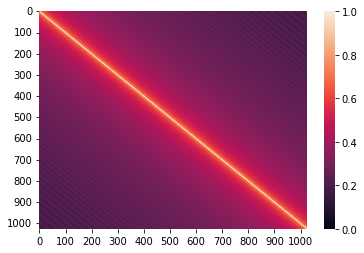

In [ ]:
pos_emb = model.decoder.embed_positions.weights.cpu().detach()
cos = nn.CosineSimilarity(dim=0)
n = pos_emb.size(0)
similarity_m = np.zeros((n, n))

for i in range(n):
    for j in range(i, n):
        cs = cos(pos_emb[i], pos_emb[j])
        similarity_m[i][j] = similarity_m[j][i] = cs
sns.heatmap(similarity_m, xticklabels=100, yticklabels=100)